In [ ]:
pip install pytorch-widedeep

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.1 MB 1.6 MB/s 
     |████████████████████████████████| 1.5 MB 35.3 MB/s 
     |████████████████████████████████| 529 kB 45.5 MB/s 
     |████████████████████████████████| 1.6 MB 51.0 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import torch
import sklearn as sk
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

from pytorch_widedeep import Trainer
from pytorch_widedeep.preprocessing import WidePreprocessor, TabPreprocessor
from pytorch_widedeep.models import Wide, TabMlp, WideDeep, SAINT, TabNetDecoder
from pytorch_widedeep.metrics import Accuracy, Precision, F1Score
from pytorch_widedeep.datasets import load_adult

from pytorch_widedeep.models.tabular.transformers import saint
from pytorch_widedeep.models.tabular.tabnet.tab_net import TabNet

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

#***Pre-processamento***

In [ ]:
def formatColunm(col, df):
  le = sk.preprocessing.LabelEncoder()
  le.fit(df[col])
  df[col] = le.transform(df[col])

In [ ]:
# Importar conjunto de dados
dfOriginal = pd.read_csv('/content/sample_data/German_Credit_dataset.csv', delimiter=",")
df = pd.read_csv('/content/sample_data/German_Credit_dataset_balanced.csv', delimiter=",")

dfOriginal.drop(["id", "'own_telephone'"], axis = 1, inplace = True)

df.drop("id", axis = 1, inplace = True)
df_train, df_test = train_test_split(df, test_size=0.3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


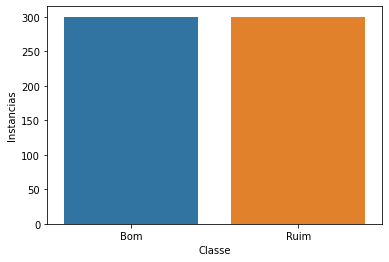

<Figure size 432x288 with 0 Axes>

In [ ]:
formatColunm("'checking_status'", dfOriginal)
formatColunm("'credit_history'", dfOriginal)
formatColunm("'purpose'", dfOriginal)
formatColunm("'savings_status'", dfOriginal)
formatColunm("'employment'", dfOriginal)
formatColunm("'personal_status'", dfOriginal)
formatColunm("'other_payment_plans'", dfOriginal)
formatColunm("'housing'", dfOriginal)
formatColunm("'job'", dfOriginal)
formatColunm("'foreign_worker'", dfOriginal)
formatColunm("'other_parties'", dfOriginal)
formatColunm("'property_magnitude'", dfOriginal)
formatColunm("'class'", dfOriginal)

shuffled_df = dfOriginal.sample(frac=1,random_state=4)

# Put all the fraud class in a separate dataset.
bad_df = shuffled_df.loc[dfOriginal["'class'"] == 0]

#Randomly select 492 observations from the non-fraud (majority class)
good_df = shuffled_df.loc[dfOriginal["'class'"] == 1].sample(n=300,random_state=42)

# Concatenate both dataframes again
normalized_df = pd.concat([good_df, bad_df])

#plot the dataset after the undersampling
ax = plt.subplot()
plt.figure()

sns.countplot("'class'", data=normalized_df, ax=ax)
ax.set_xlabel('Classe');ax.set_ylabel('Instancias'); 
ax.xaxis.set_ticklabels(['Bom', 'Ruim']);

dfO_train, dfO_test = train_test_split(normalized_df, test_size=0.4)

In [ ]:
# Define the 'column set up'
wide_cols = [
]

crossed_cols = [("'duration'", "'credit_amount'"), ("'duration'", "'age'"), ("'age'", "'credit_amount'"), ("'credit_amount'", "'purpose'"), ("'foreign_worker'", "'housing'")]

cat_embed_cols = [
    "'checking_status'",
    "'credit_history'",
    "'purpose'",
    "'savings_status'",
    "'employment'",
    "'installment_commitment'",
    "'personal_status'",
    "'other_payment_plans'",
    "'num_dependents'",
    "'existing_credits'",
    "'other_parties'",
    "'property_magnitude'"
]

continuous_cols = ["'age'", "'duration'"]

target = "'class'"
target = df_train[target].values

df.head()

,'checking_status','duration','credit_history','purpose','credit_amount','savings_status','employment','installment_commitment','personal_status','other_parties',...,'property_magnitude','age','other_payment_plans','housing','existing_credits','job','num_dependents','own_telephone','foreign_worker','class'
0,1,6,1,6,1169,4,3,4,3,2,...,3,67,1,1,2,1,1,1,1,1
1,0,48,3,6,5951,2,0,2,0,2,...,3,22,1,1,1,1,1,0,1,0
2,3,12,1,2,2096,2,1,2,3,2,...,3,49,1,1,1,3,2,0,1,1
3,1,42,3,3,7882,2,1,2,3,1,...,1,45,1,0,1,1,2,0,1,1
4,1,24,2,4,4870,2,0,3,3,2,...,2,53,1,0,2,1,2,0,1,0


In [ ]:
# prepare the data
wide_preprocessor = WidePreprocessor(wide_cols=wide_cols, crossed_cols=crossed_cols)
X_wide = wide_preprocessor.fit_transform(df_train)

tab_preprocessor = TabPreprocessor(
    cat_embed_cols=cat_embed_cols, continuous_cols=continuous_cols  # type: ignore[arg-type]
)

X_tab = tab_preprocessor.fit_transform(df_train)

wide = Wide(input_dim=np.unique(X_wide).shape[0], pred_dim=1)

params = {
        "column_idx": tab_preprocessor.column_idx,
        "cat_embed_input": tab_preprocessor.cat_embed_input,
        "continuous_cols": tab_preprocessor.continuous_cols,
    }


#***SAINT***

In [ ]:
saint = SAINT(input_dim=32, n_heads=8, n_blocks=2, transformer_activation='relu', ff_dropout=0.6, **params)



model_saint = WideDeep(wide=wide, deeptabular=saint)

In [ ]:
# train and validate
trainer = Trainer(model_saint, objective="binary", metrics=[Accuracy, Precision, F1Score])

trainer.fit(
    X_wide=X_wide,
    X_tab=X_tab,
    target=target,
    n_epochs=100,
    batch_size=4,
    finetune=True,
)


Training wide for 5 epochs


epoch 5: 100%|██████████| 245/245 [00:04<00:00, 52.95it/s, loss=0.393, metrics={'acc': 0.7004, 'prec': 0.6882, 'f1': 0.7066}]


Training deeptabular for 5 epochs


epoch 5: 100%|██████████| 245/245 [00:34<00:00,  7.13it/s, loss=0.711, metrics={'acc': 0.6056, 'prec': 0.6008, 'f1': 0.6078}]


Fine-tuning (or warmup) of individual components completed. Training the whole model for 100 epochs


epoch 100: 100%|██████████| 245/245 [00:35<00:00,  6.96it/s, loss=0.00762, metrics={'acc': 1.0, 'prec': 1.0, 'f1': 1.0}]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

# predict on test
X_wide_te = wide_preprocessor.transform(dfO_test)
X_tab_te = tab_preprocessor.transform(dfO_test)
preds = trainer.predict(X_wide=X_wide_te, X_tab=X_tab_te, batch_size=1)
Y_true = dfO_test.values[:,-1]
accuracy_score(preds, Y_true)

print(classification_report(Y_true, preds))

print(confusion_matrix(Y_true, preds))

predict:  98%|█████████▊| 60/61 [00:01<00:00, 46.49it/s]


              precision    recall  f1-score   support

           0       0.81      0.88      0.84       117
           1       0.88      0.80      0.84       123

    accuracy                           0.84       240
   macro avg       0.84      0.84      0.84       240
weighted avg       0.84      0.84      0.84       240

[[103  14]
 [ 24  99]]


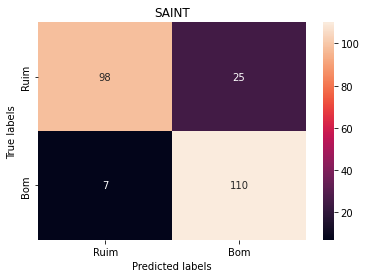

<Figure size 432x288 with 0 Axes>

In [ ]:
ax = plt.subplot()

plt.figure()
sns.heatmap(confusion_matrix(Y_true, preds), annot=True, fmt=".0f", ax=ax)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.set_title('SAINT'); 
ax.xaxis.set_ticklabels(['Ruim', 'Bom']); ax.yaxis.set_ticklabels(['Ruim', 'Bom']);


#***TabNet***

In [ ]:
tabnet = TabNet(**params, n_steps=3, step_dim=8, attn_dim=8, gamma=1.1)
model_tabnet = WideDeep(wide=wide, deeptabular=tabnet)


/usr/local/lib/python3.7/dist-packages/pytorch_widedeep/models/wide_deep.py:394: UserWarning: 'WideDeep' is a model comprised by multiple components and the 'deeptabular' component is 'TabNet'. We recommend using 'TabNet' in isolation. The reasons are: i)'TabNet' uses sparse regularization which partially losses its purpose when used in combination with other components. If you still want to use a multiple component model with 'TabNet', consider setting 'lambda_sparse' to 0 during training. ii) The feature importances will be computed only for TabNet but the model will comprise multiple components. Therefore, such importances will partially lose their 'meaning'.
  UserWarning,


In [ ]:
trainerTabnet = Trainer(model_tabnet, objective="binary", metrics=[Accuracy, Precision, F1Score], lambda_sparse = 0)

trainerTabnet.fit(
    X_wide=X_wide,
    X_tab=X_tab,
    target=target,
    n_epochs=100,
    batch_size=4,
)


epoch 5: 100%|██████████| 245/245 [00:08<00:00, 29.53it/s, loss=0.0214, metrics={'acc': 0.9959, 'prec': 0.9939, 'f1': 0.9959}]


predict:  98%|█████████▊| 60/61 [00:01<00:00, 57.98it/s]


              precision    recall  f1-score   support

           0       0.94      0.81      0.87       126
           1       0.82      0.94      0.87       114

    accuracy                           0.87       240
   macro avg       0.88      0.87      0.87       240
weighted avg       0.88      0.87      0.87       240



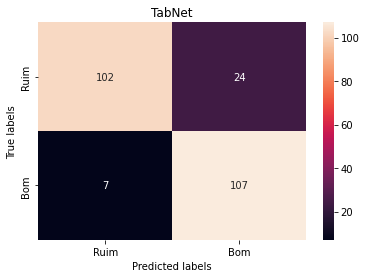

<Figure size 432x288 with 0 Axes>

In [ ]:
# predict on test
X_wide_te = wide_preprocessor.transform(dfO_test)
X_tab_te = tab_preprocessor.transform(dfO_test)
predsTabNet = trainerTabnet.predict(X_wide=X_wide_te, X_tab=X_tab_te, batch_size=1)
Y_true = dfO_test.values[:,-1]

print(classification_report(Y_true, predsTabNet))

ax = plt.subplot()
plt.figure()
sns.heatmap(confusion_matrix(Y_true, predsTabNet), annot=True, fmt=".0f", ax=ax)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('TabNet'); 
ax.xaxis.set_ticklabels(['Ruim', 'Bom']); ax.yaxis.set_ticklabels(['Ruim', 'Bom']);